# PFI Notes

- Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect the intrinsic predictive value of a feature by itself but how important this feature is for a particular model.
- Permutation importances can be computed either on the training set or on a held-out testing or validation set. Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit.
- The importance values are relative to the model and dataset used — they don’t tell $why$ the feature is important
- Importance values add up (or sum) to the total drop in performance only in special cases; with interactions, they overlap and the sum may exceed. 
- The ranking of the features is approximately the same for different metrics even if the scales of the importance values are very different. However, this is not guaranteed and different metrics might lead to significantly different feature importances, in particular for models trained for imbalanced classification problems, for which the choice of the classification metric can be critical. 
- When two features are correlated and one of the features is permuted, the model still has access to the latter through its correlated feature. This results in a lower reported importance value for both features, though they might actually be important.
- Interpretation: the “conditional PFI” measures loss increase due to losing the *unique* information of the feature (not that which is shared via correlations).
- Always evaluate on a test / hold-out dataset, not the training set, to avoid over-estimating importance
- Repeat permutations multiple times (M > 1) and average, to reduce variance due to random shuffling
- Be cautious when features are highly correlated – interpret importance in light of dependencies. Consider conditional methods.
- Use PFI along with other interpretability tools (e.g., partial dependence plots, SHAP) for a more complete picture

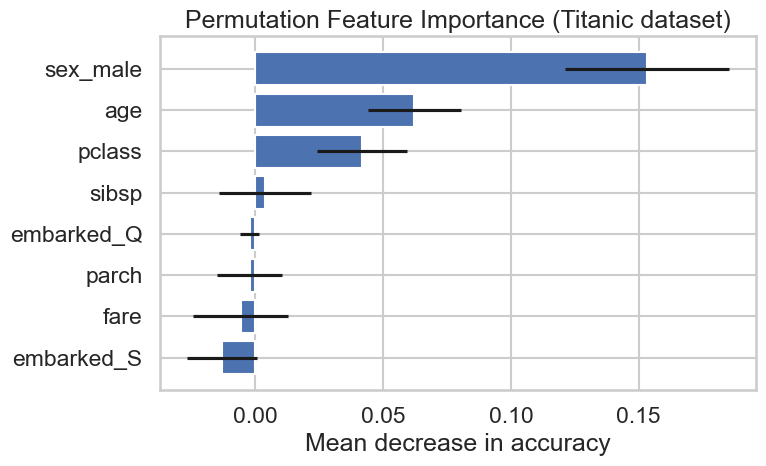

In [8]:
# --- Imports ---
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# --- Load dataset (Titanic from seaborn) ---
titanic = sns.load_dataset("titanic")

# --- Basic preprocessing ---
# Select useful numeric/categorical features
features = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
titanic = titanic[features + ["survived"]].dropna()

# Convert categorical to numeric
titanic = pd.get_dummies(titanic, drop_first=True)

# Split data
X = titanic.drop("survived", axis=1)
y = titanic["survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# --- Compute permutation feature importance ---
r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# --- Create results DataFrame ---
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=True)

# --- Plot ---
plt.figure(figsize=(8,5))
plt.barh(importance_df["feature"], importance_df["importance_mean"], xerr=importance_df["importance_std"])
plt.xlabel("Mean decrease in accuracy")
plt.title("Permutation Feature Importance (Titanic dataset)")
plt.tight_layout()
plt.show()


In [4]:
# 🖼️ Matplotlib settings

#sns.set_style("whitegrid")

plt.rcParams.update({
    'text.usetex': True,          # Enable LaTeX rendering
    'font.family': 'serif',       # Use serif fonts for a classic look
    'font.serif': ['Georgia'],    # Specify a serif font (e.g., Georgia)
    'figure.dpi': 200,            # Set the default DPI for clear visuals
    'figure.facecolor': 'white',  # Set the figure background color
    "axes.edgecolor": "grey",     # Border color for axes
    "axes.linewidth": 0.2,        # Border width for axes
    'axes.grid': True,            # Enable grid on axes
    'grid.color': 'grey',         # Grid color
    'grid.linestyle': '--',       # Dashed grid line style
    'grid.linewidth': 0.3,       # Grid line width
    'grid.alpha': 0.5,            # Grid transparency
    "axes.spines.top": False,     # Remove top spine
    "axes.spines.right": False,   # Remove right spine
    "legend.frameon": True,       # Enable frame around legends
    "legend.framealpha": 0.5      # Legend frame transparency
})

warnings.filterwarnings('ignore')

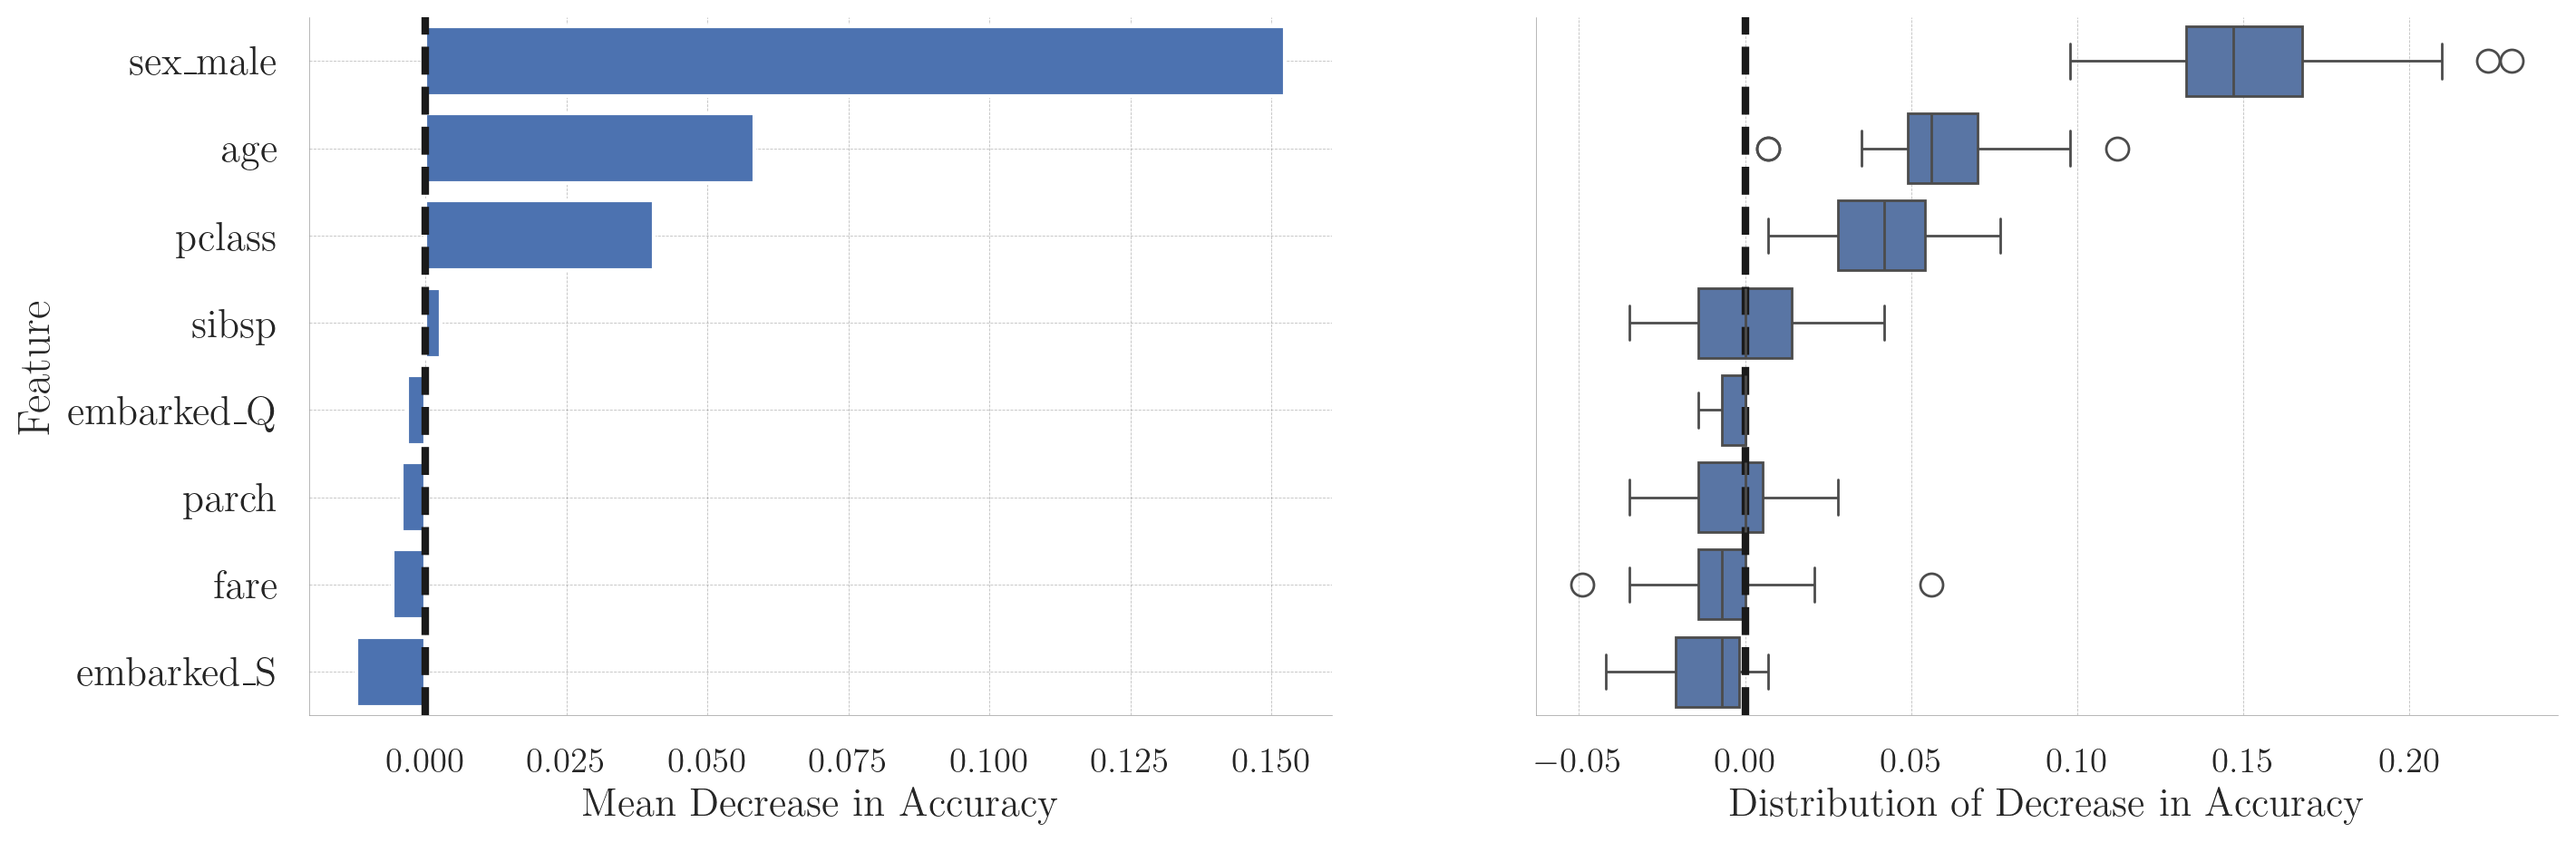

In [44]:
# --- Imports ---
import warnings
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

sns.color_palette("rocket", as_cmap=True)

# --- Load dataset (Titanic from seaborn) ---
titanic = sns.load_dataset("titanic")

# --- Basic preprocessing ---
# Select useful numeric/categorical features
features = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
titanic = titanic[features + ["survived"]].dropna()

# Convert categorical to numeric
titanic = pd.get_dummies(titanic, drop_first=True)

# Split data
X = titanic.drop("survived", axis=1)
y = titanic["survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# --- Compute permutation feature importance ---
r = permutation_importance(model, X_test, y_test, n_repeats=50, random_state=42)

# --- Create results DataFrame for sorting ---
# This is still needed to get the correct sorted order
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

# Get the sorted list of feature names
sorted_features = importance_df["feature"]

# --- Create DataFrame for Boxplot ---
# Reshape the r.importances (n_features, n_repeats) array into a long-form DataFrame
# 1. Create a DataFrame from the transposed importances, with features as columns
importances_tidy_df = pd.DataFrame(r.importances.T, columns=X.columns)
# 2. "Melt" the DataFrame into a long-form
#    This creates two columns: 'feature' and 'importance'
importances_tidy_df = importances_tidy_df.melt(var_name='feature', value_name='importance')


# --- Create Side-by-Side Plots ---

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# --- Plot 1: Bar Plot (Left) ---
axes[0].barh(importance_df["feature"], importance_df["importance_mean"])
axes[0].set_xlabel("Mean Decrease in Accuracy", fontsize=16)
#axes[0].set_title("PFI Mean")
axes[0].axvline(0, color='k', linestyle='--', linewidth=3) # Add zero line
axes[0].set_ylabel("Feature", fontsize=18)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=16)

# --- Plot 2: Box Plot (Right) ---
sns.boxplot(
    data=importances_tidy_df,
    x='importance',
    y='feature',
    order=sorted_features,  # Use the same sorted order as the bar plot
    orient='h',
    ax=axes[1]
)
axes[1].set_xlabel("Distribution of Decrease in Accuracy", fontsize=16)
#axes[1].set_title("PFI Distribution")
axes[1].axvline(0, color='k', linestyle='--', linewidth=3) # Add zero line
axes[1].set_ylabel("", fontsize=1) # Hide the y-label as it's shared
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)

#plt.suptitle("Permutation Feature Importance (Titanic Dataset)", fontsize=20, fontweight="bold")
plt.savefig("permutation_feature_importance_titanic.png", bbox_inches='tight', dpi=300)
plt.show()

Model accuracy: 0.7622


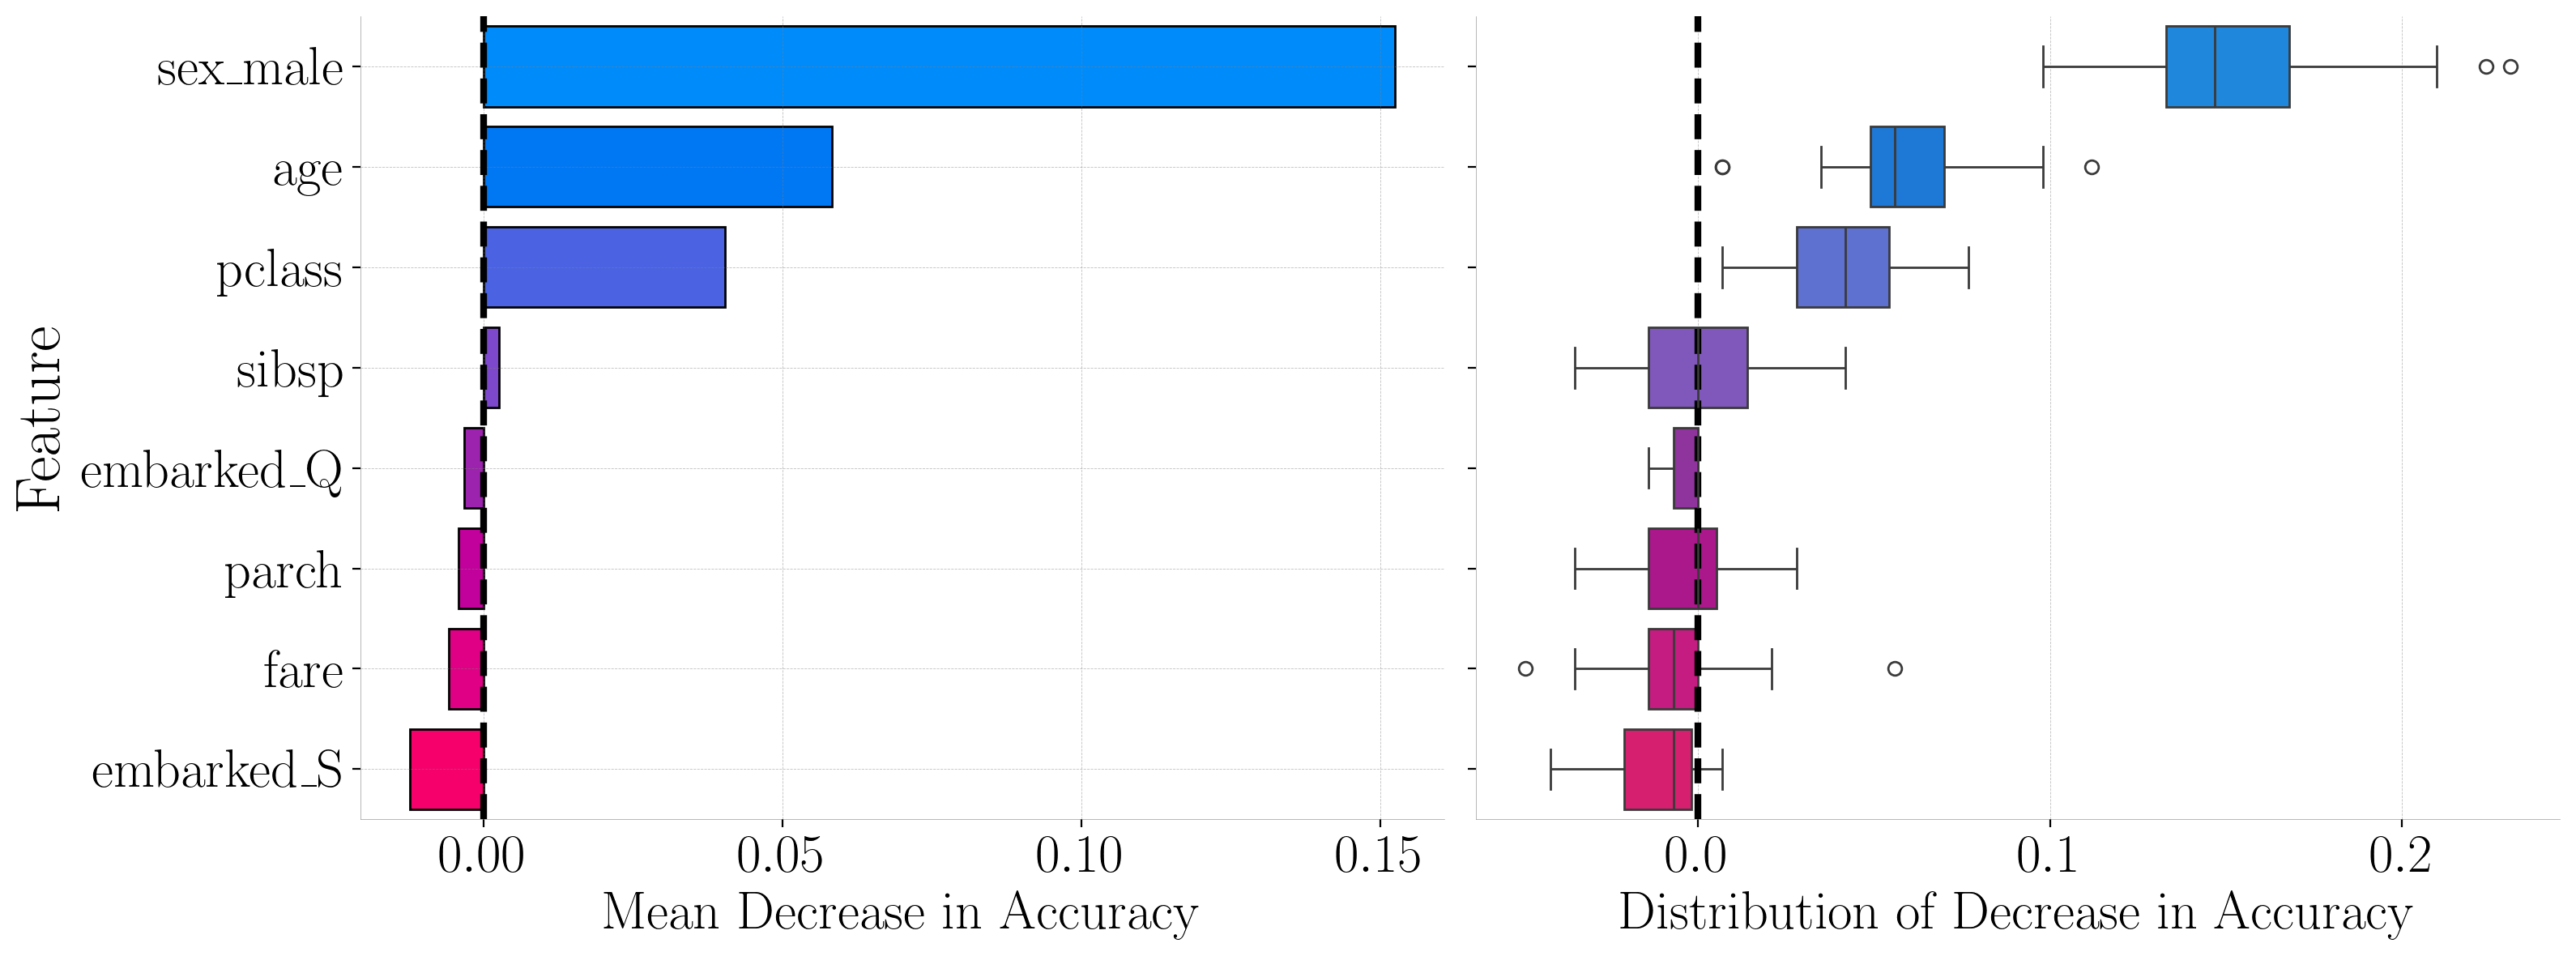

In [ ]:

# --- Imports ---
import warnings
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shap
import matplotlib.colors as mcolors

# --- Load dataset ---
titanic = sns.load_dataset("titanic")

# --- Preprocessing ---
features = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
titanic = titanic[features + ["survived"]].dropna()
titanic = pd.get_dummies(titanic, drop_first=True)

X = titanic.drop("survived", axis=1)
y = titanic["survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.4f}")

# --- Permutation Feature Importance ---
r = permutation_importance(model, X_test, y_test, n_repeats=50, random_state=42)

# --- Create importance DataFrame ---
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

sorted_features = importance_df["feature"].tolist()

# --- Create long-form DataFrame for Boxplot ---
importances_tidy_df = pd.DataFrame(r.importances.T, columns=X.columns)
importances_tidy_df = importances_tidy_df.melt(var_name='feature', value_name='importance')

# --- Create consistent color mapping ---
shap_cmap = shap.plots.colors.red_blue  
palette = [mcolors.to_hex(shap_cmap(i / len(X.columns))) for i in range(len(X.columns))]
feature_colors = dict(zip(sorted_features, palette))

# --- Plot setup ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# --- Bar Plot (Left) ---
bar_colors = [feature_colors[f] for f in sorted_features]
axes[0].barh(
    importance_df["feature"],
    importance_df["importance_mean"],
    color=bar_colors,
    edgecolor="black"
)
axes[0].invert_yaxis()  # ensures same top-to-bottom order as boxplot
axes[0].axvline(0, color='k', linestyle='--', linewidth=3)
axes[0].set_xlabel("Mean Decrease in Accuracy", fontsize=24)
axes[0].set_ylabel("Feature", fontsize=28)
axes[0].tick_params(axis='x', labelsize=24)
axes[0].tick_params(axis='y', labelsize=24)

# --- Box Plot (Right) ---
sns.boxplot(
    data=importances_tidy_df,
    x='importance',
    y='feature',
    order=sorted_features,
    orient='h',
    ax=axes[1],
    palette=feature_colors
)
axes[1].axvline(0, color='k', linestyle='--', linewidth=3)
axes[1].set_xlabel("Distribution of Decrease in Accuracy", fontsize=24)
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', labelsize=24)
axes[1].tick_params(axis='y', labelsize=24)

# --- Title and layout ---
plt.tight_layout()
plt.show()


Model accuracy: 0.7622


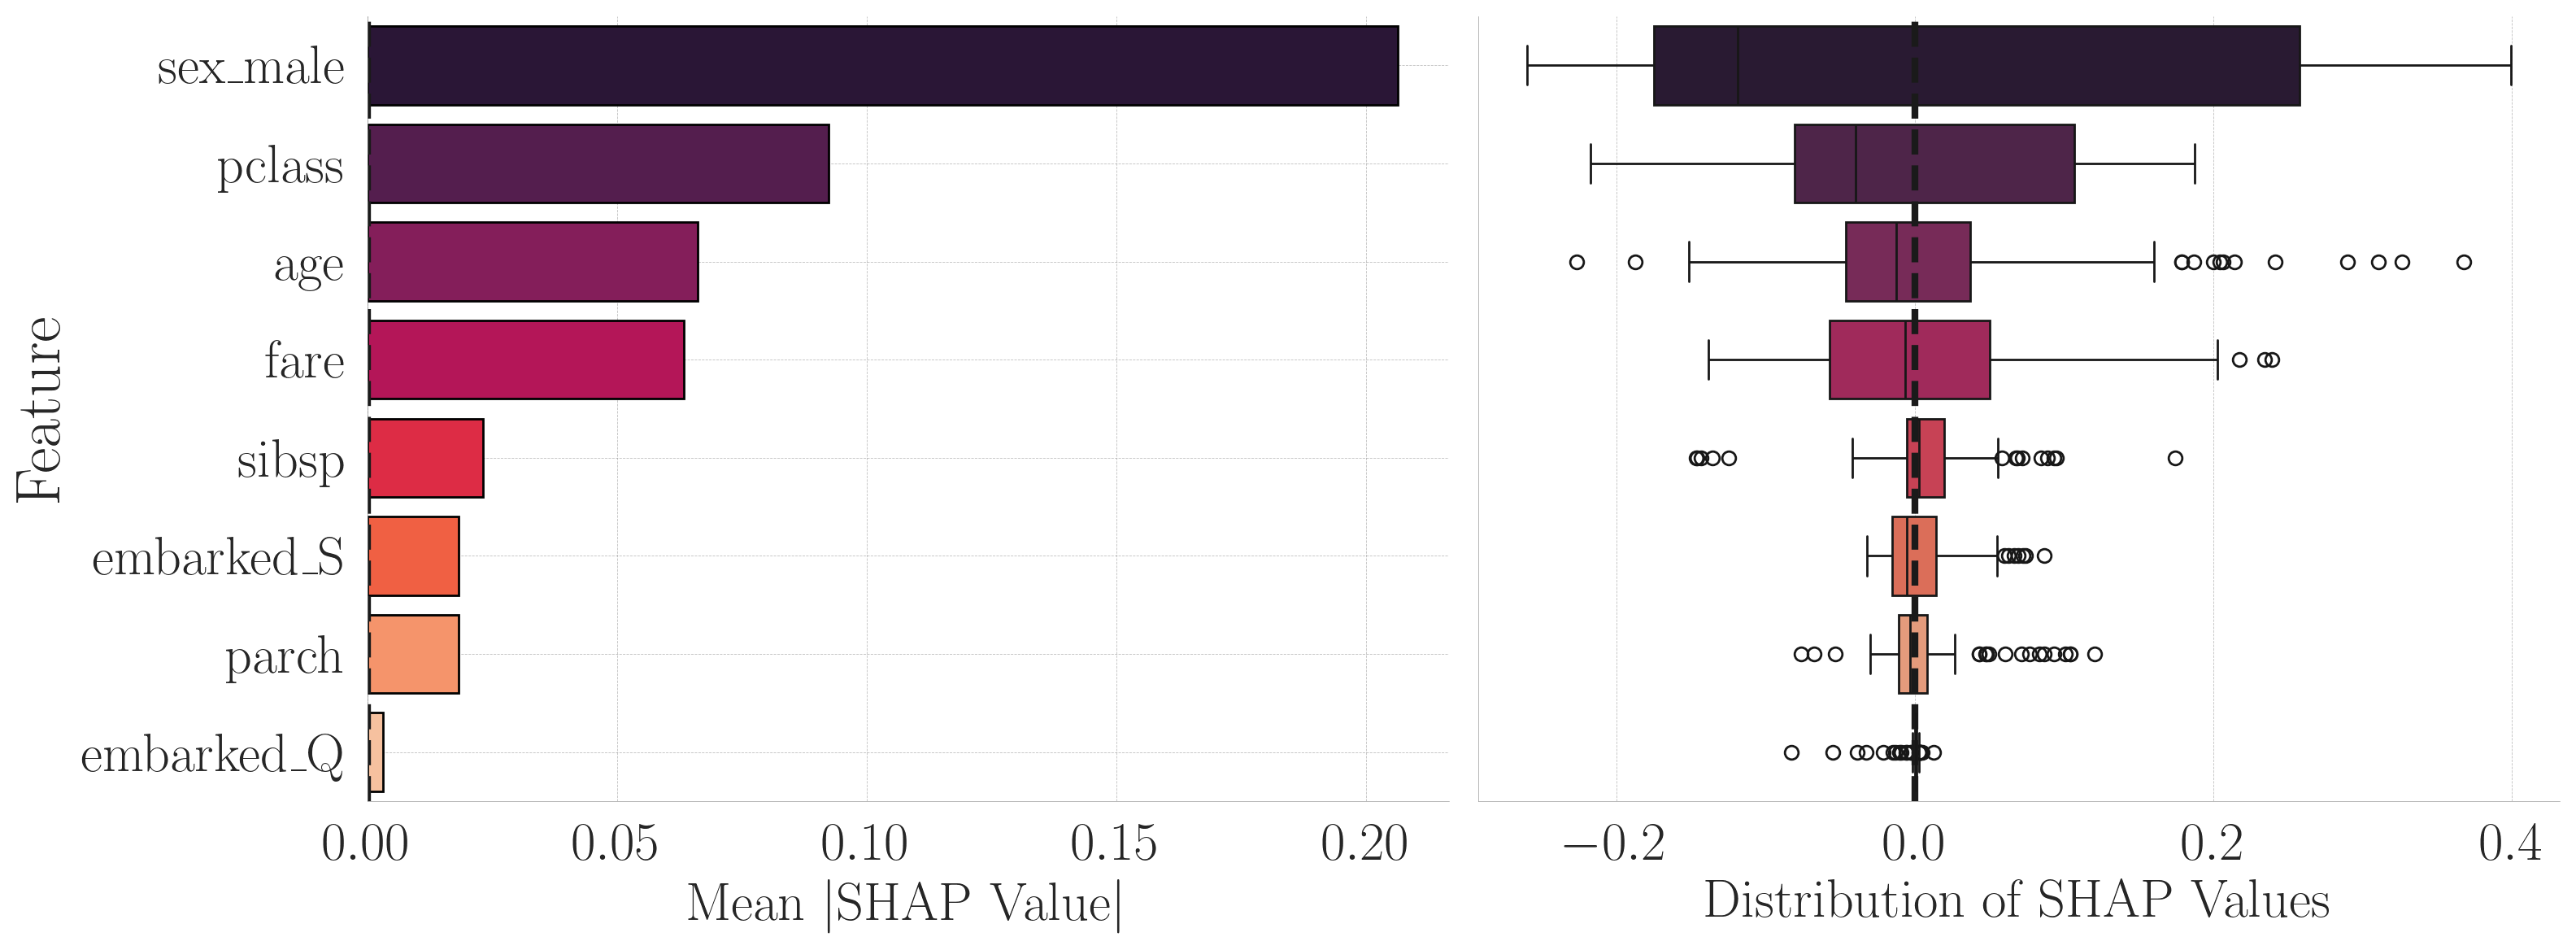

In [85]:

    # --- Imports ---
    import warnings
    import pandas as pd
    import seaborn as sns
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    import matplotlib.pyplot as plt
    import numpy as np
    import shap

    # --- Load dataset ---
    titanic = sns.load_dataset("titanic")

    # --- Preprocessing ---
    features = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
    titanic = titanic[features + ["survived"]].dropna()
    titanic = pd.get_dummies(titanic, drop_first=True)

    X = titanic.drop("survived", axis=1)
    y = titanic["survived"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Train model ---
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    #check model performance
    accuracy = model.score(X_test, y_test)
    print(f"Model accuracy: {accuracy:.4f}")

    # --- Compute SHAP values ---
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # --- Handle SHAP output shape ---
    # Some versions return list of arrays (one per class)
    # Others return 3D array (n_samples, n_features, n_classes)
    if isinstance(shap_values, list):
        shap_values_class1 = shap_values[0]  # use positive class
    elif shap_values.ndim == 3:
        shap_values_class1 = shap_values[:, :, 1]
    else:
        shap_values_class1 = shap_values  # already 2D

    # --- Create importance DataFrame ---
    importance_mean = np.abs(shap_values_class1).mean(axis=0)
    importance_std = np.abs(shap_values_class1).std(axis=0)

    importance_df = pd.DataFrame({
        "feature": X.columns,
        "importance_mean": importance_mean.flatten(),
        "importance_std": importance_std.flatten()
    }).sort_values("importance_mean", ascending=False)

    sorted_features = importance_df["feature"].tolist()

    # --- Create long-form DataFrame for Boxplot ---
    importances_tidy_df = pd.DataFrame(shap_values_class1, columns=X.columns)
    importances_tidy_df = importances_tidy_df.melt(var_name='feature', value_name='importance')

    # --- Create consistent color mapping ---
    palette = sns.color_palette("rocket", n_colors=len(sorted_features))
    feature_colors = dict(zip(sorted_features, palette))

    # --- Plot setup ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # --- Bar Plot (Left) ---
    bar_colors = [feature_colors[f] for f in sorted_features]
    axes[0].barh(
        importance_df["feature"],
        importance_df["importance_mean"],
        color=bar_colors,
        edgecolor="black"
    )
    axes[0].invert_yaxis()
    axes[0].axvline(0, color='k', linestyle='--', linewidth=3)
    axes[0].set_xlabel("Mean $|$SHAP Value$|$", fontsize=24)
    axes[0].set_ylabel("Feature", fontsize=28)
    axes[0].tick_params(axis='x', labelsize=24)
    axes[0].tick_params(axis='y', labelsize=24)

    # --- Box Plot (Right) ---
    sns.boxplot(
        data=importances_tidy_df,
        x='importance',
        y='feature',
        order=sorted_features,
        orient='h',
        ax=axes[1],
        palette=feature_colors
    )
    axes[1].axvline(0, color='k', linestyle='--', linewidth=3)
    axes[1].set_xlabel("Distribution of SHAP Values", fontsize=24)
    axes[1].set_ylabel("")
    axes[1].tick_params(axis='x', labelsize=24)
    axes[1].tick_params(axis='y', labelsize=24)

    # --- Title and layout ---
    plt.tight_layout()
    plt.savefig("shap_feature_importance_titanic_fixed.png", bbox_inches="tight", dpi=300)
    plt.show()


In [86]:
titanic.shape

(712, 9)

In [88]:
shap_values[1]

array([[-0.12714822,  0.12714822],
       [ 0.0357327 , -0.0357327 ],
       [-0.04573249,  0.04573249],
       [ 0.00137747, -0.00137747],
       [-0.12797216,  0.12797216],
       [-0.28676437,  0.28676437],
       [-0.00085995,  0.00085995],
       [-0.04155038,  0.04155038]])

Model accuracy: 0.7622


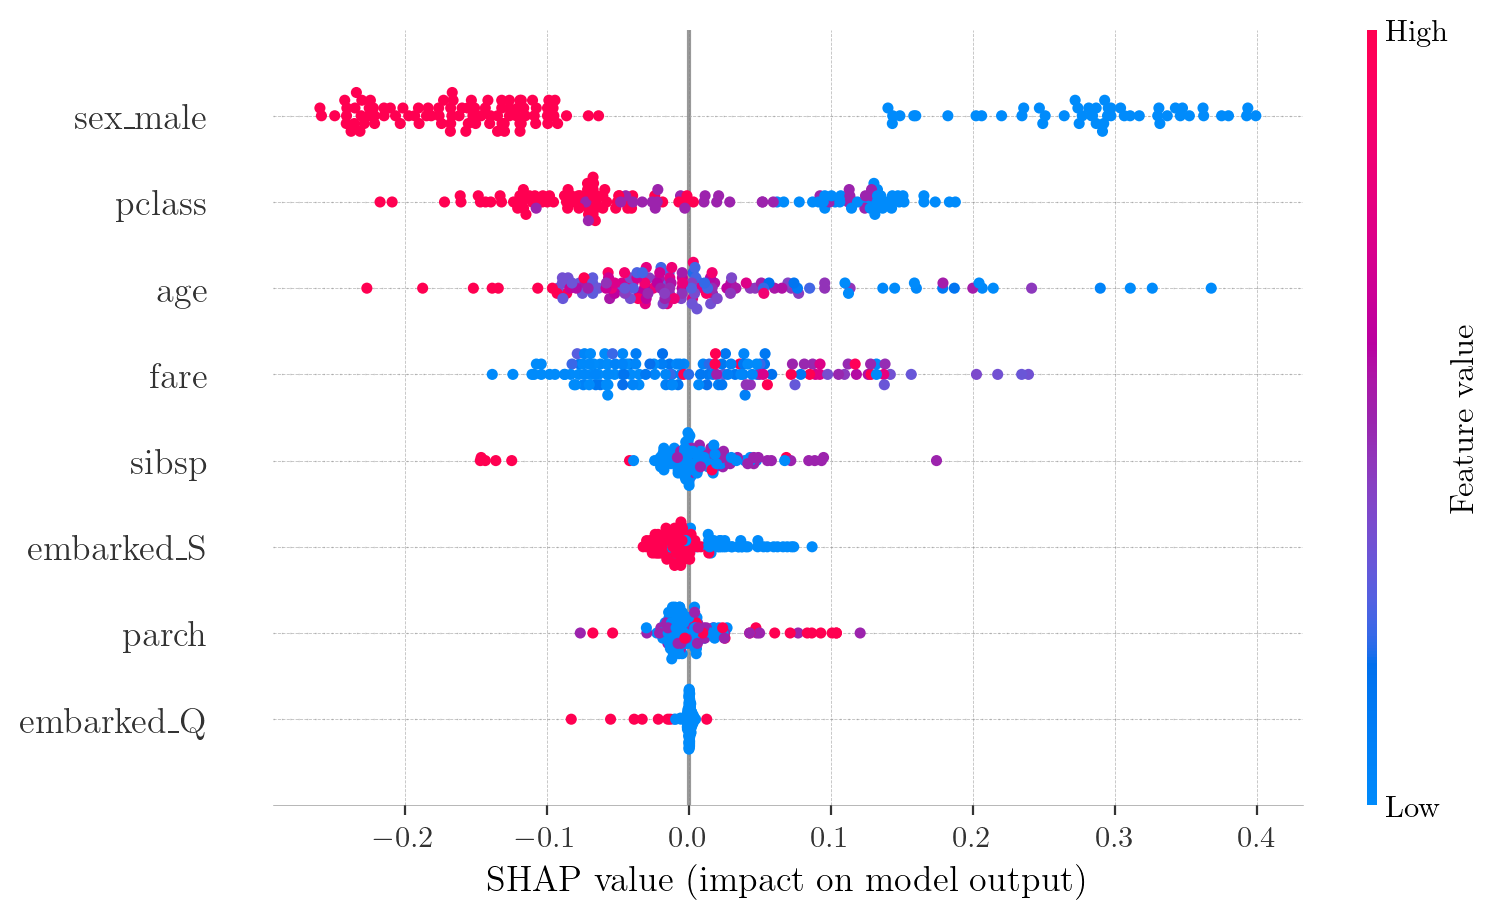

In [9]:
# --- Imports ---
import warnings
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import shap

# --- Load dataset ---
titanic = sns.load_dataset("titanic")

# --- Preprocessing ---
features = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
titanic = titanic[features + ["survived"]].dropna()
titanic = pd.get_dummies(titanic, drop_first=True)

X = titanic.drop("survived", axis=1)
y = titanic["survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# --- Check model performance ---
accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.4f}")

# --- Compute SHAP values ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# --- Handle SHAP output shape ---
#For binary classification, shap_values is often a list [class0, class1]
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]  # positive class
elif shap_values.ndim == 3:
    shap_values_class1 = shap_values[:, :, 1]
else:
    shap_values_class1 = shap_values

# --- SHAP Summary Plot ---
plt.figure(figsize=(16, 2))
shap.summary_plot(
    shap_values_class1,#shap_values_class1, 
    X_test,
    plot_type="dot",  # beeswarm plot (default)
    show=True
)
